In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from string import Template
from sklearn.metrics import mean_absolute_percentage_error

import modules.src.kalman.plots as plots

from modules.src.kalman.utils import *
from modules.src.kalman.filters import * 
from modules.src.kalman.auxilary import * 

In [2]:
data = pd.read_excel(".\\etc\\data.xlsx")
data.head()

,begin,SBERBANK_open,SBERBANK_close,SBERBANK_high,SBERBANK_low,SBERBANK_value,SBERBANK_volume,SBERBANK_end,GAZPROM_open,GAZPROM_close,...,GAZPROM_value,GAZPROM_volume,GAZPROM_end,SEVERSTAL_open,SEVERSTAL_close,SEVERSTAL_high,SEVERSTAL_low,SEVERSTAL_value,SEVERSTAL_volume,SEVERSTAL_end
0,2023-01-03 09:59:00,141.98,141.98,141.98,141.98,623292.2,4390.0,2023-01-03 09:59:59,163.00,163.00,...,3202950.0,19650.0,2023-01-03 09:59:59,901.4,901.4,901.4,901.4,544445.6,604.0,2023-01-03 09:59:59
1,2023-01-03 10:00:00,141.39,141.77,141.98,141.35,5222705.0,36870.0,2023-01-03 10:00:59,163.02,162.97,...,9785043.9,60010.0,2023-01-03 10:00:59,902.4,900.0,903.0,899.4,2977627.8,3304.0,2023-01-03 10:00:59
2,2023-01-03 10:01:00,141.75,141.66,141.99,141.47,2848250.1,20070.0,2023-01-03 10:01:59,162.91,162.51,...,4853519.7,29840.0,2023-01-03 10:01:59,900.0,900.2,900.6,899.4,1663076.8,1848.0,2023-01-03 10:01:59
3,2023-01-03 10:02:00,141.58,141.64,141.66,141.58,1172537.4,8280.0,2023-01-03 10:02:59,162.51,162.66,...,6973666.8,42910.0,2023-01-03 10:02:59,900.0,899.6,900.0,899.2,336374.6,374.0,2023-01-03 10:02:59
4,2023-01-03 10:03:00,141.64,141.70,141.74,141.64,508607.6,3590.0,2023-01-03 10:03:59,162.66,162.44,...,5747959.5,35360.0,2023-01-03 10:03:59,899.6,900.0,900.2,899.6,1099767.4,1222.0,2023-01-03 10:03:59


In [3]:
companies = "SBERBANK", "GAZPROM", "SEVERSTAL"

cols = "open", "close", "high", "low", "volume"

col_template = Template("$company$col")

df = {}

for company in companies: 
    cols2fetch = [col_template.substitute(company=company+"_", col=col) for col in cols]
    df[company] = data[["begin"]+cols2fetch]

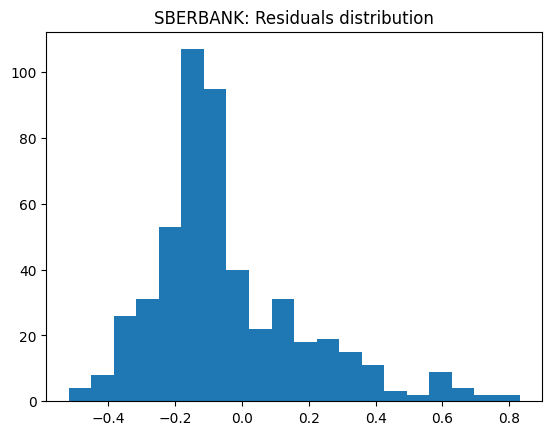

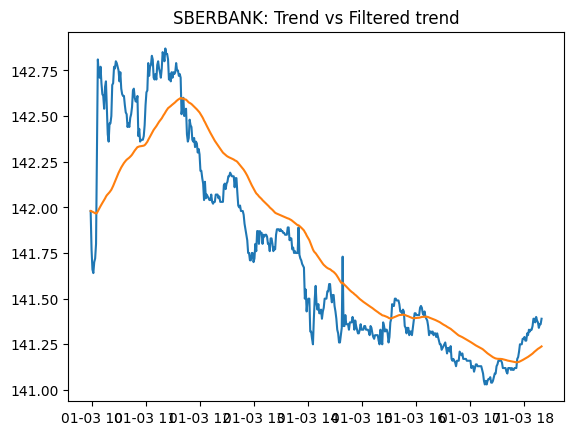

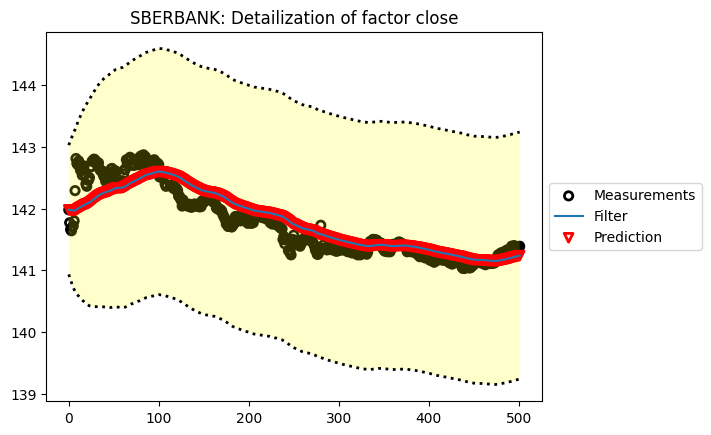

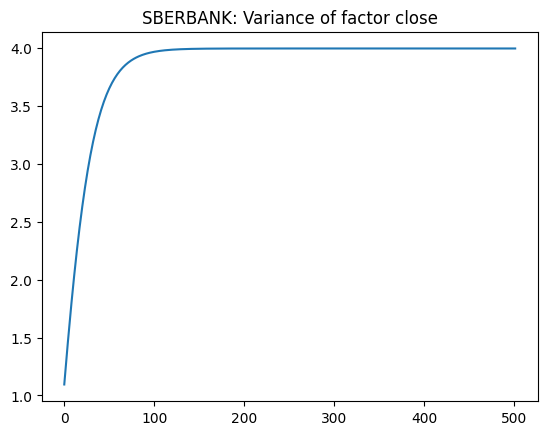

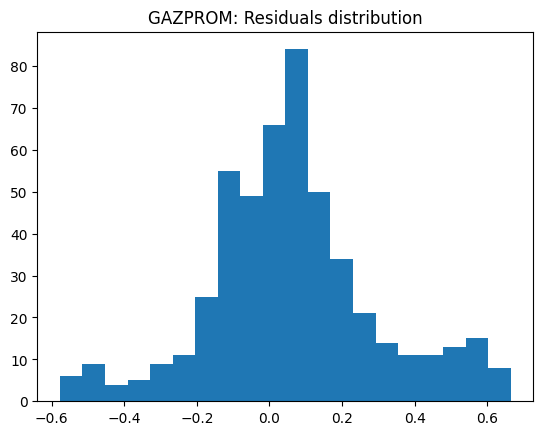

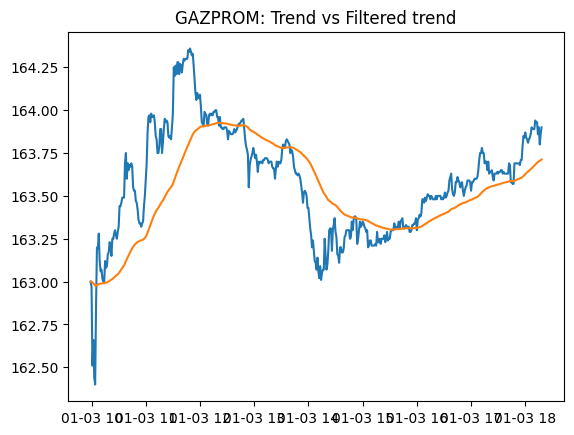

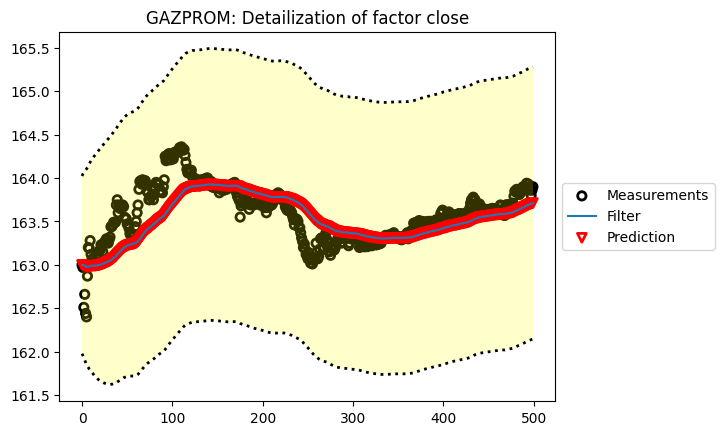

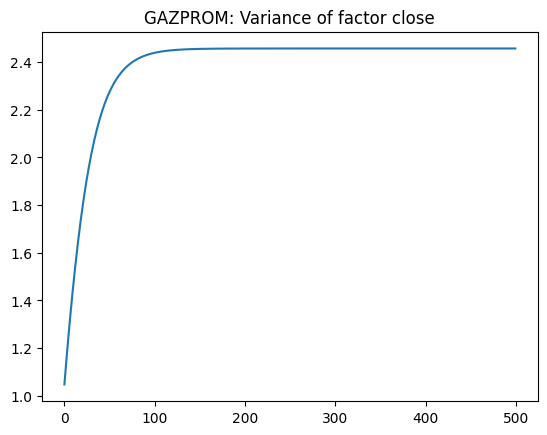

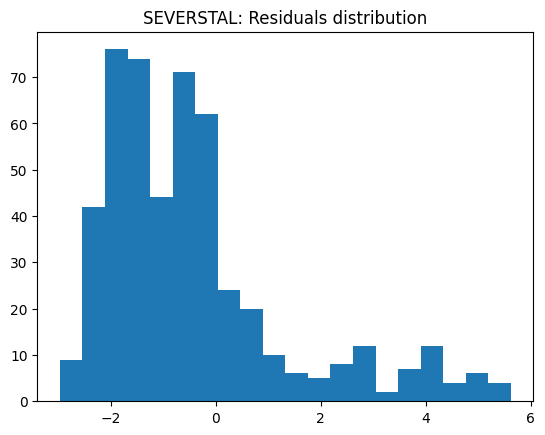

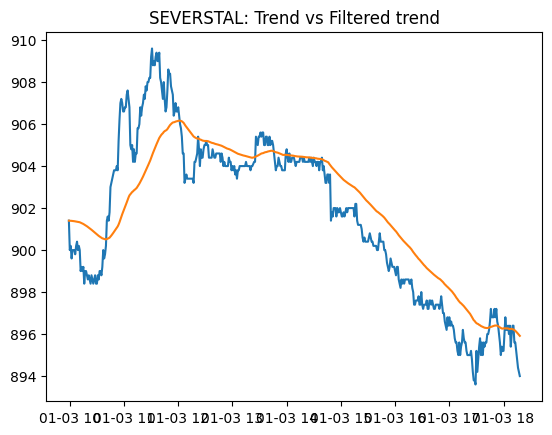

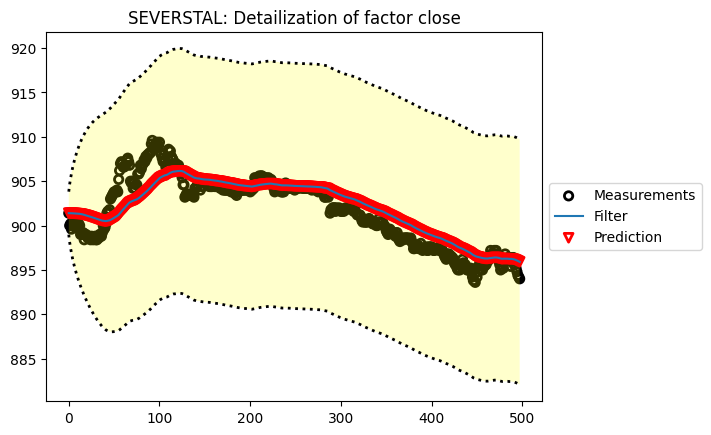

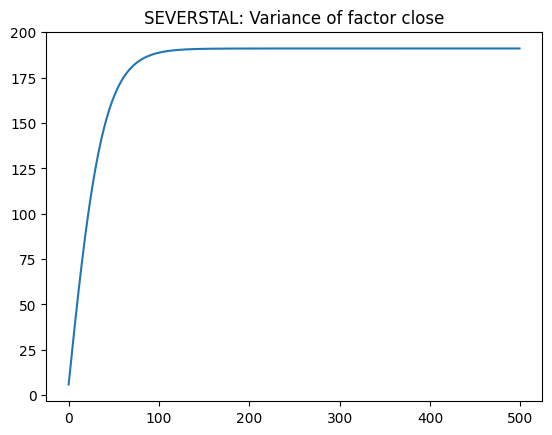

In [4]:
# Однофакторная модель на основе оценки MLE
COMPANY = "SBERBANK"
for COMPANY in companies:
    COL_GROUP = "begin"
    COL_DATA = "close"
    COL_DATA_FULL = f"{COMPANY}_{COL_DATA}"

    df_proc = df[COMPANY][[COL_GROUP, COL_DATA_FULL]].dropna()

    daily_groups = df_proc.groupby(pd.Grouper(key=COL_GROUP, freq="D"))

    filtered_data = []
    filtered_data_vars = []

    # Для каждой упорядоченной группы ...
    for _, group in daily_groups:
        if not group.empty:
            # инициализирующая генерация матриц
            matrices = generate_kalman_matrices_from_timeseries_old(group.filter(like=COL_DATA))
            Z = group[COL_DATA_FULL].to_numpy()

            filter_hist_states = np.empty(shape=Z.shape[0])
            filter_vars_states = np.empty(shape=Z.shape[0])

            optimized_params = optimize_kalman_parameters(
                Z=Z,
                Q_init=matrices['Q'],
                R_init=matrices['R'],
                x_init=matrices['x0'],
                P_init=matrices['P'],
                method='MLE'
            )

            kf = BaseKalmanFilter(
                F=matrices['F'],
                H=matrices['H'],
                Q=optimized_params['Q_opt'],
                R=optimized_params['R_opt'],
                P=matrices['P'],
                x0=matrices['x0']
            )

            for t in range(Z.shape[0]):
                observation = Z[t]

                kf.predict()
                kf.update(observation)

                filter_hist_states[t] = kf.get_state()[0]
                filter_vars_states[t] = kf.P[0,0]

            filtered_data.append(filter_hist_states)
            filtered_data_vars.append(filter_vars_states)

        break

    filtered_data = np.hstack(filtered_data)        
    filtered_data_vars = np.hstack(filtered_data_vars)

    processed_df = pd.concat([df_proc.begin, 
                            df_proc[COL_DATA_FULL],
                            pd.DataFrame(filtered_data, columns=["pred"]),
                            pd.DataFrame(filtered_data_vars, columns=["var_pred"])], axis=1).dropna()
    
    plt.hist(processed_df[COL_DATA_FULL] - processed_df["pred"], bins=20)
    plt.title(f'{COMPANY}: Residuals distribution')

    plt.show()

    plt.plot(processed_df.begin, processed_df[COL_DATA_FULL])
    plt.plot(processed_df.begin, processed_df["pred"])
    plt.title(f'{COMPANY}: Trend vs Filtered trend')

    plt.show()

    plots.plot_measurements(processed_df[COL_DATA_FULL])
    plots.plot_filter(processed_df["pred"], var=processed_df["var_pred"])
    plots.plot_predictions(processed_df["pred"])
    plots.show_legend()
    plt.title(f"{COMPANY}: Detailization of factor {COL_DATA}")

    plt.show()

    plt.plot(filtered_data_vars)
    plt.title(f'{COMPANY}: Variance of factor {COL_DATA}')

    plt.show()

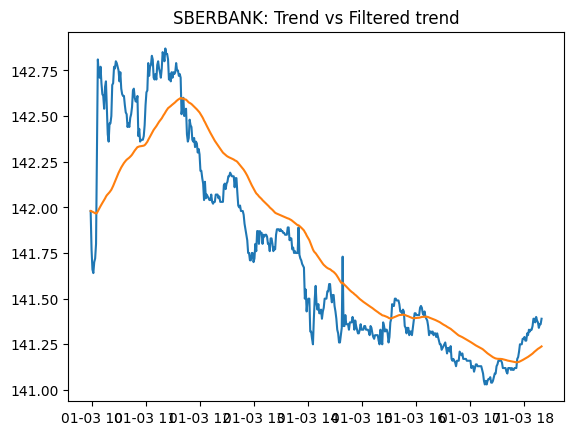

C:\Users\dbezu\AppData\Local\Temp\ipykernel_206508\2332311547.py:57: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  group[COL_DATA_FULL][t] = kf.get_state()[0]
C:\Users\dbezu\AppData\Local\Temp\ipykernel_206508\2332311547.py:57: SettingWithCo

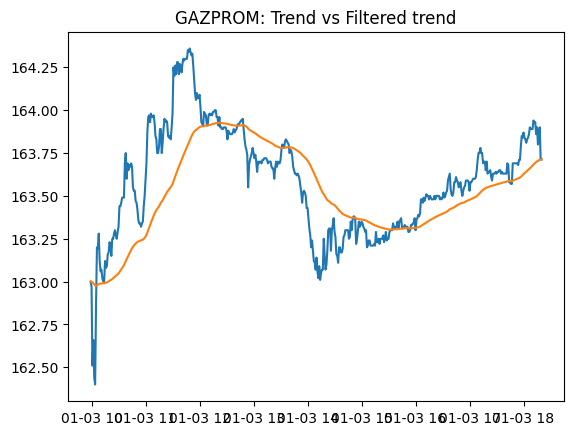

C:\Users\dbezu\AppData\Local\Temp\ipykernel_206508\2332311547.py:57: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  group[COL_DATA_FULL][t] = kf.get_state()[0]
C:\Users\dbezu\AppData\Local\Temp\ipykernel_206508\2332311547.py:57: SettingWithCo

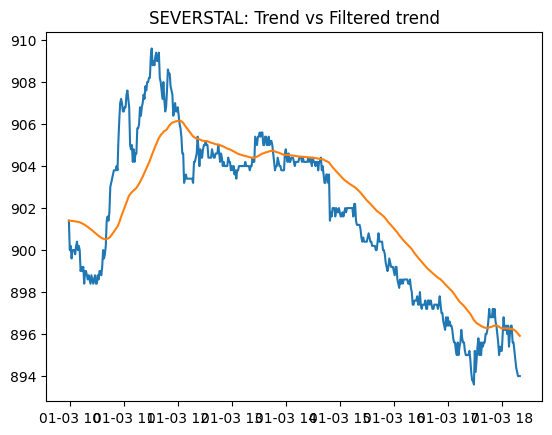

In [5]:
# заполнение пропусков

# Однофакторная модель на основе оценки MLE
COMPANY = "SBERBANK"
for COMPANY in companies:
    COL_GROUP = "begin"
    COL_DATA = "close"
    COL_DATA_FULL = f"{COMPANY}_{COL_DATA}"

    df_proc = df[COMPANY][[COL_GROUP, COL_DATA_FULL]]

    daily_groups = df_proc.groupby(pd.Grouper(key=COL_GROUP, freq="D"))

    filtered_data = []
    filtered_data_vars = []

    # Для каждой упорядоченной группы ...
    for _, group in daily_groups:
        if not group.empty:
            # инициализирующая генерация матриц
            matrices = generate_kalman_matrices_from_timeseries_old(group.filter(like=COL_DATA).dropna())
            Z = group[COL_DATA_FULL].dropna().to_numpy()

            filter_hist_states = np.empty(shape=group.shape[0])

            optimized_params = optimize_kalman_parameters(
                Z=Z,
                Q_init=matrices['Q'],
                R_init=matrices['R'],
                x_init=matrices['x0'],
                P_init=matrices['P'],
                method='MLE'
            )

            kf = BaseKalmanFilter(
                F=matrices['F'],
                H=matrices['H'],
                Q=optimized_params['Q_opt'],
                R=optimized_params['R_opt'],
                P=matrices['P'],
                x0=matrices['x0']
            )

            for t in range(group[COL_DATA_FULL].shape[0]):
                observation = group[COL_DATA_FULL][t]
                if observation == observation:

                    kf.predict()
                    kf.update(observation)

                    filter_hist_states[t] = kf.get_state()[0]

                else: 
                    kf.predict()
                    
                    filter_hist_states[t] = kf.get_state()[0]
                    group[COL_DATA_FULL][t] = kf.get_state()[0]

            filtered_data.append(filter_hist_states)

        break

    filtered_data = np.hstack(filtered_data)        

    processed_df = pd.concat([group.begin, 
                            group[COL_DATA_FULL],
                            pd.DataFrame(filtered_data, columns=["pred"])], axis=1).dropna()

    plt.plot(processed_df.begin, processed_df[COL_DATA_FULL])
    plt.plot(processed_df.begin, processed_df["pred"])
    plt.title(f'{COMPANY}: Trend vs Filtered trend')

    plt.show()

C:\Users\dbezu\AppData\Local\Temp\ipykernel_206508\3630343914.py:22: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  group[COL_DATA_FULL][nan_replacement] = np.nan
C:\Users\dbezu\AppData\Local\Temp\ipykernel_206508\3630343914.py:22: SettingWit

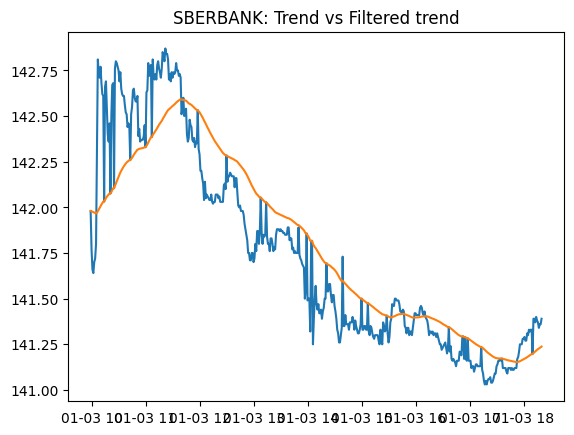

C:\Users\dbezu\AppData\Local\Temp\ipykernel_206508\3630343914.py:22: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  group[COL_DATA_FULL][nan_replacement] = np.nan
C:\Users\dbezu\AppData\Local\Temp\ipykernel_206508\3630343914.py:22: SettingWit

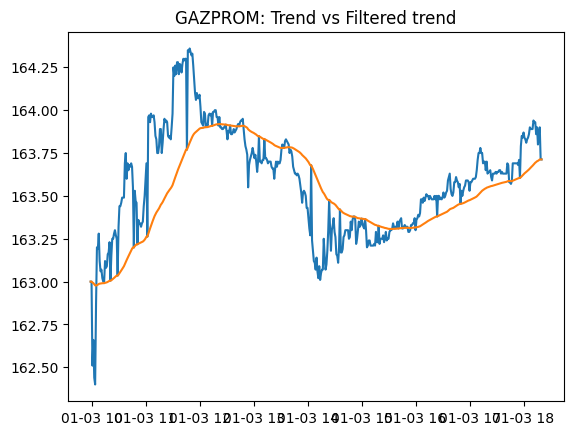

C:\Users\dbezu\AppData\Local\Temp\ipykernel_206508\3630343914.py:22: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  group[COL_DATA_FULL][nan_replacement] = np.nan
C:\Users\dbezu\AppData\Local\Temp\ipykernel_206508\3630343914.py:22: SettingWit

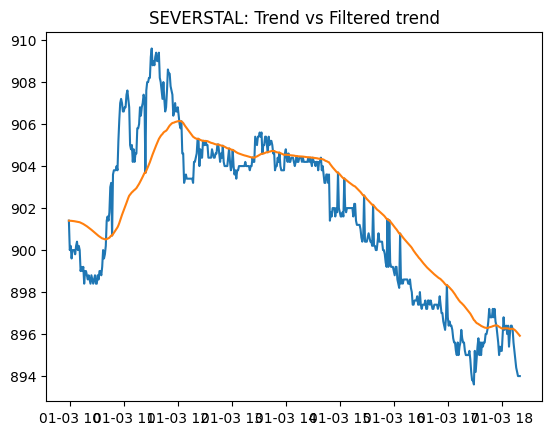

In [6]:
# больше NAN опций

# Однофакторная модель на основе оценки MLE
COMPANY = "SBERBANK"
for COMPANY in companies:
    COL_GROUP = "begin"
    COL_DATA = "close"
    COL_DATA_FULL = f"{COMPANY}_{COL_DATA}"

    df_proc = df[COMPANY][[COL_GROUP, COL_DATA_FULL]]

    daily_groups = df_proc.groupby(pd.Grouper(key=COL_GROUP, freq="D"))

    filtered_data = []
    filtered_data_vars = []

    # Для каждой упорядоченной группы ...
    for _, group in daily_groups:
        if not group.empty:
            # инициализирующая генерация матриц
            nan_replacement = group[COL_DATA_FULL].sample(frac=.05).index
            group[COL_DATA_FULL][nan_replacement] = np.nan

            matrices = generate_kalman_matrices_from_timeseries_old(group.filter(like=COL_DATA).dropna())
            Z = group[COL_DATA_FULL].dropna().to_numpy()

            filter_hist_states = np.empty(shape=group.shape[0])

            optimized_params = optimize_kalman_parameters(
                Z=Z,
                Q_init=matrices['Q'],
                R_init=matrices['R'],
                x_init=matrices['x0'],
                P_init=matrices['P'],
                method='MLE'
            )

            kf = BaseKalmanFilter(
                F=matrices['F'],
                H=matrices['H'],
                Q=optimized_params['Q_opt'],
                R=optimized_params['R_opt'],
                P=matrices['P'],
                x0=matrices['x0']
            )

            for t in range(group[COL_DATA_FULL].shape[0]):
                observation = group[COL_DATA_FULL][t]
                if observation == observation:

                    kf.predict()
                    kf.update(observation)

                    filter_hist_states[t] = kf.get_state()[0]

                else: 
                    kf.predict()
                    
                    filter_hist_states[t] = kf.get_state()[0]
                    group[COL_DATA_FULL][t] = kf.get_state()[0]

            filtered_data.append(filter_hist_states)

        break

    filtered_data = np.hstack(filtered_data)        

    processed_df = pd.concat([group.begin, 
                            group[COL_DATA_FULL],
                            pd.DataFrame(filtered_data, columns=["pred"])], axis=1).dropna()

    plt.plot(processed_df.begin, processed_df[COL_DATA_FULL])
    plt.plot(processed_df.begin, processed_df["pred"])
    plt.title(f'{COMPANY}: Trend vs Filtered trend')

    plt.show()

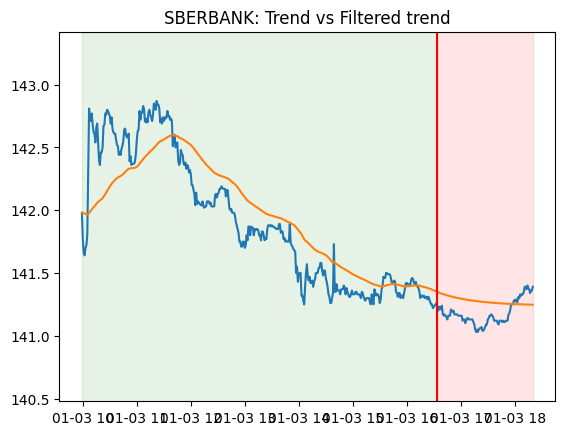

MAPE for this series for houldout: 0.0009498980509268042


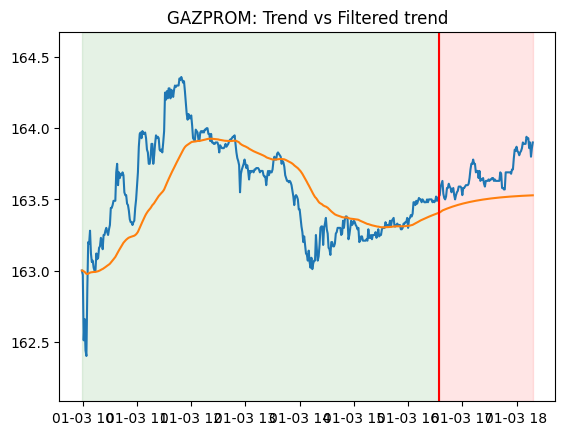

MAPE for this series for houldout: 0.0011160043057776871


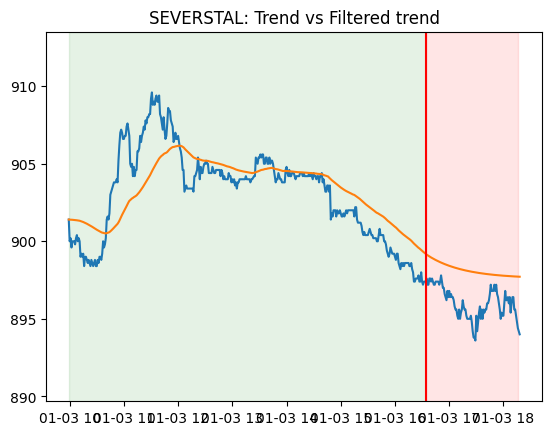

MAPE for this series for houldout: 0.002393278343188945


In [7]:
# больше NAN опций

# Однофакторная модель на основе оценки MLE
COMPANY = "SEVERSTAL"
for COMPANY in companies:
    
    COL_GROUP = "begin"
    COL_DATA = "close"
    COL_DATA_FULL = f"{COMPANY}_{COL_DATA}"

    df_proc = df[COMPANY][[COL_GROUP, COL_DATA_FULL]]

    daily_groups = df_proc.groupby(pd.Grouper(key=COL_GROUP, freq="D"))

    filtered_data = []
    filtered_data_vars = []

    # Для каждой упорядоченной группы ...
    for _, group in daily_groups:
        if not group.empty:
            # инициализирующая генерация матриц
            matrices = generate_kalman_matrices_from_timeseries_old(group.filter(like=COL_DATA).dropna())
            Z = group[COL_DATA_FULL].dropna().to_numpy()

            filter_hist_states = np.empty(shape=Z.shape[0])

            optimized_params = optimize_kalman_parameters(
                Z=Z,
                Q_init=matrices['Q'],
                R_init=matrices['R'],
                x_init=matrices['x0'],
                P_init=matrices['P'],
                method='MLE'
            )

            kf = BaseKalmanFilter(
                F=matrices['F'],
                H=matrices['H'],
                Q=optimized_params['Q_opt'],
                R=optimized_params['R_opt'],
                P=matrices['P'],
                x0=matrices['x0']
            )

            for t in range(Z.shape[0]):
                if t <= 400:
                    observation = Z[t]

                    kf.predict()
                    kf.update(observation)

                else:
                    kf.predict()
                    kf.update(observation)

                filter_hist_states[t] = kf.get_state()[0]

            filtered_data.append(filter_hist_states)

        break

    filtered_data = np.hstack(filtered_data)        

    processed_df = pd.concat([group.begin, 
                            group[COL_DATA_FULL],
                            pd.DataFrame(filtered_data, columns=["pred"])], axis=1).dropna()

    top = processed_df[COL_DATA_FULL].max() + processed_df[COL_DATA_FULL].std()
    bottom = processed_df[COL_DATA_FULL].min() - processed_df[COL_DATA_FULL].std()

    plt.plot(processed_df.begin, processed_df[COL_DATA_FULL])
    plt.plot(processed_df.begin, processed_df["pred"])
    plt.axvline(processed_df.begin[400-5], color="red")

    plt.fill_between([processed_df.begin[0], processed_df.begin[0], processed_df.begin[400-5], processed_df.begin[400-5]], 
                     [bottom, top, top, bottom], alpha=.1, color="g")
    plt.fill_between([processed_df.begin[400-5], processed_df.begin[400-5], processed_df.begin[processed_df.shape[0]-1], processed_df.begin[processed_df.shape[0]-1]], 
                     [bottom, top, top, bottom], alpha=.1, color="r")
    plt.ylim(top=processed_df[COL_DATA_FULL].max() + processed_df[COL_DATA_FULL].std())
    plt.ylim(bottom=processed_df[COL_DATA_FULL].min() - processed_df[COL_DATA_FULL].std())
    plt.title(f'{COMPANY}: Trend vs Filtered trend')

    plt.show()

    plt.show()

    print(f"MAPE for this series for houldout: {mean_absolute_percentage_error(processed_df[COL_DATA_FULL][400-5:], processed_df["pred"][400-5:])}")

[[0.1]] [[0.40386372]]


C:\Users\dbezu\AppData\Local\Temp\ipykernel_206508\3156780084.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  filter_vars_states[t] = ekf.P
C:\Users\dbezu\AppData\Local\Temp\ipykernel_206508\3156780084.py:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  filter_vars_states[t] = ekf.P


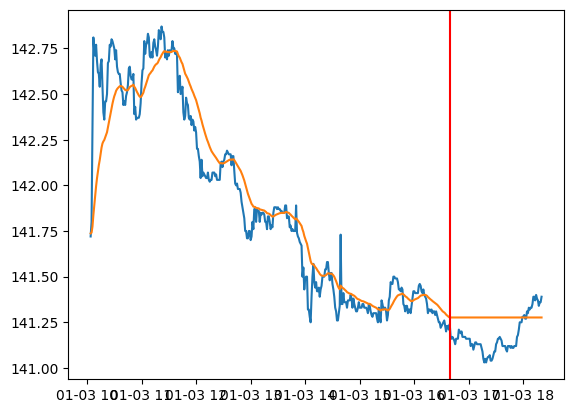

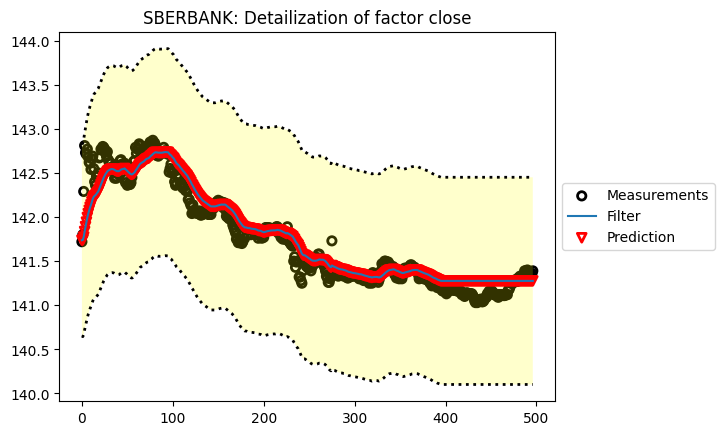

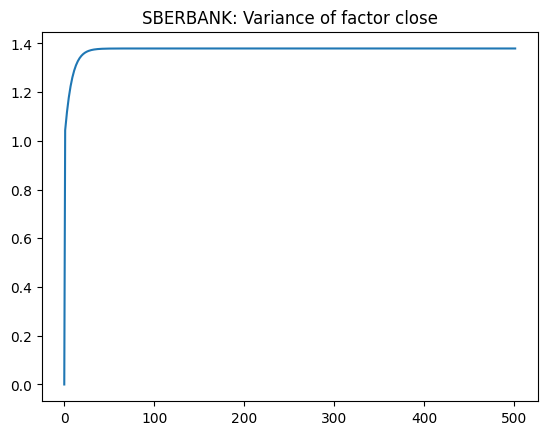

MAPE for this series for houldout: 0.0008889360648952695
[[0.1]] [[0.20103321]]


C:\Users\dbezu\AppData\Local\Temp\ipykernel_206508\3156780084.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  filter_vars_states[t] = ekf.P
C:\Users\dbezu\AppData\Local\Temp\ipykernel_206508\3156780084.py:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  filter_vars_states[t] = ekf.P


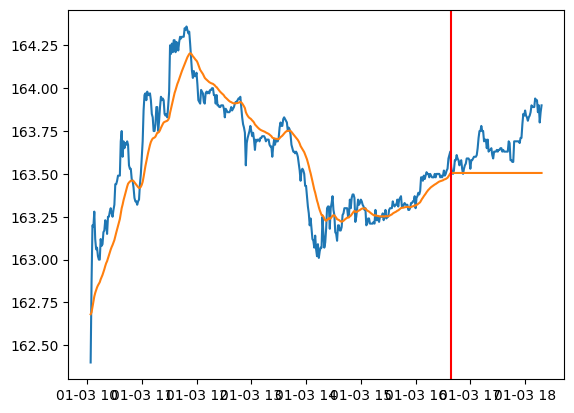

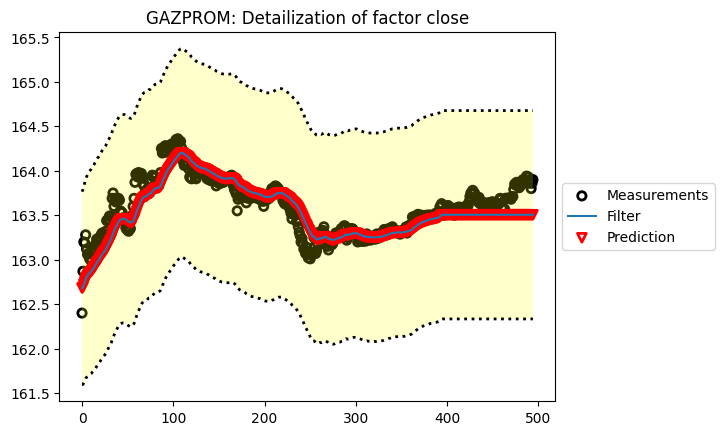

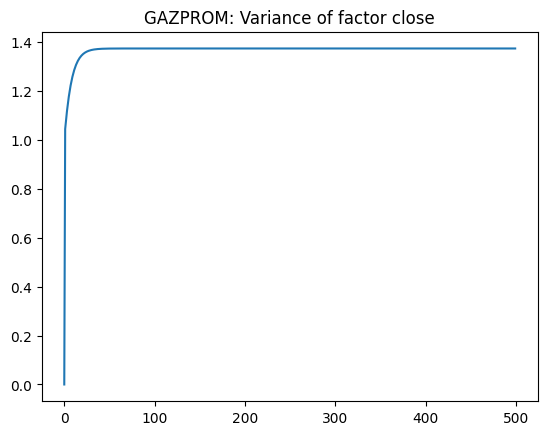

MAPE for this series for houldout: 0.0010597104247085983
[[0.1]] [[15.58119296]]


C:\Users\dbezu\AppData\Local\Temp\ipykernel_206508\3156780084.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  filter_vars_states[t] = ekf.P
C:\Users\dbezu\AppData\Local\Temp\ipykernel_206508\3156780084.py:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  filter_vars_states[t] = ekf.P


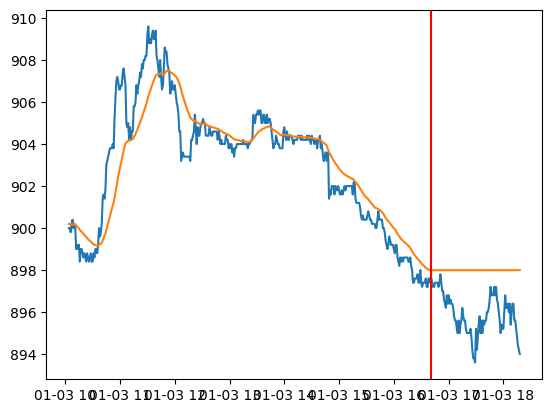

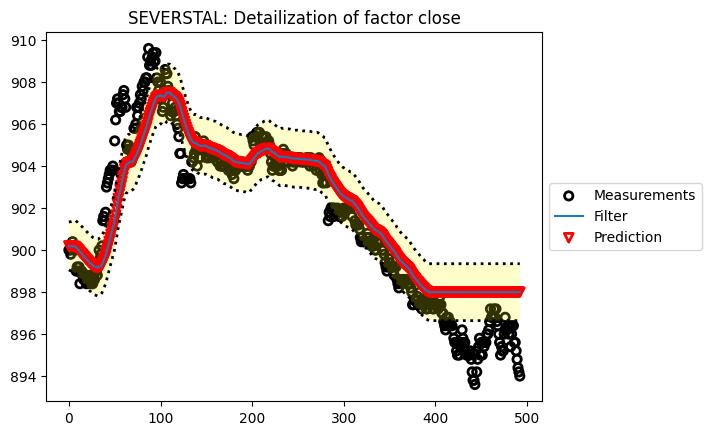

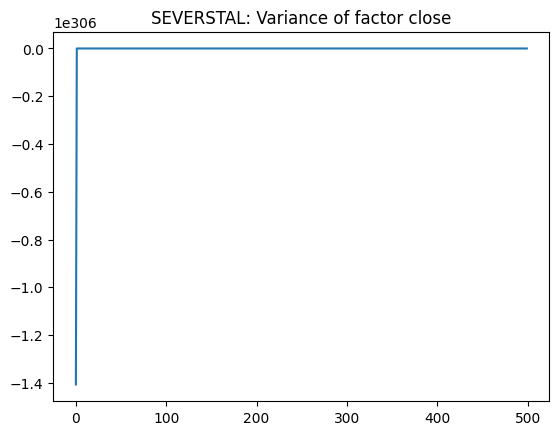

MAPE for this series for houldout: 0.002310521474077353


In [8]:
# Предсказания

# COMPANY = "SBERBANK"
for COMPANY in companies:
    COL_GROUP = "begin"
    COL_DATA = "close"
    COL_DATA_FULL = f"{COMPANY}_{COL_DATA}"

    df_proc = df[COMPANY][[COL_GROUP, COL_DATA_FULL]].dropna()

    daily_groups = df_proc.groupby(pd.Grouper(key=COL_GROUP, freq="D"))

    filtered_data = []
    filtered_data_vars = []

    def F_func(x, t):
        return np.array([x[0]])

    def H_func(x, t):
        return np.array([x[0]])

    state_dim = 1

    for _, group in daily_groups:
        if not group.empty:
            filter_hist_states = np.empty(shape=group.shape[0])
            filter_vars_states = np.empty(shape=group.shape[0])

            F, H, Q, R, P0, x0 = generate_kalman_matrices_from_timeseries(
                time_series_data=group.filter(like=COL_DATA), state_dimension=state_dim, process_noise_scale=0.1, measurement_noise_scale=0.1, initial_estimation_error_scale=1.0
            )

            
            print(Q, R)
            R = R + 20

            ekf = ExtendedKalmanFilter(F_func=F_func, H_func=H_func, Q=Q, R=R, x0=x0.flatten(), P0=P0)

            for t in range(1, group.shape[0]):

                if t <= 400: 
                    observation = group.filter(like=COL_DATA).iloc[t]

                    ekf.predict(t)
                    ekf.update(observation, t)
                    filter_hist_states[t] = ekf.get_state()[0]
                    filter_vars_states[t] = ekf.P

                else: 
                    # observation = filter_hist_states[t-1]
                    ekf.predict(t)
                    ekf.update(ekf.get_state()[0], t)
                    filter_hist_states[t] = ekf.get_state()[0]
                    filter_vars_states[t] = ekf.P
                
            filtered_data.append(filter_hist_states)
            filtered_data_vars.append(filter_vars_states)

        break


    filtered_data = np.hstack(filtered_data)        
    filtered_data_vars = np.hstack(filtered_data_vars)

    processed_df = pd.concat([df_proc.begin, 
                            df_proc[COL_DATA_FULL],
                            pd.DataFrame(filtered_data, columns=["pred"]),
                            pd.DataFrame(filtered_data_vars, columns=["var_pred"])], axis=1).dropna()[5:].reset_index()

    plt.plot(processed_df.begin, processed_df[COL_DATA_FULL])
    plt.plot(processed_df.begin, processed_df["pred"])
    plt.axvline(processed_df.begin[400-5], color="red")
    
    plt.show()

    plots.plot_measurements(processed_df[COL_DATA_FULL])
    plots.plot_filter(processed_df["pred"], var=processed_df["var_pred"])
    plots.plot_predictions(processed_df["pred"])
    plots.show_legend()
    plt.title(f"{COMPANY}: Detailization of factor {COL_DATA}")

    plt.show()

    plt.plot(filtered_data_vars)
    plt.title(f'{COMPANY}: Variance of factor {COL_DATA}')

    plt.show()

    print(f"MAPE for this series for houldout: {mean_absolute_percentage_error(processed_df[COL_DATA_FULL][400-5:], processed_df["pred"][400-5:])}")

1
[[0.8]] [[1.]] [[0.1]] [[1.8725502]] [[1.]] [[148.38]]
                  begin  SBERBANK_close        pred
0   2023-01-13 09:59:00          148.80  148.535422
1   2023-01-13 10:00:00          148.56  148.542734
2   2023-01-13 10:01:00          148.29  148.477087
3   2023-01-13 10:02:00          148.30  148.434857
4   2023-01-13 10:03:00          147.95  148.325313
..                  ...             ...         ...
495 2023-01-13 18:14:00          150.68  150.169815
496 2023-01-13 18:15:00          150.69  150.169815
497 2023-01-13 18:16:00          150.81  150.169815
498 2023-01-13 18:17:00          150.76  150.169815
499 2023-01-13 18:18:00          150.69  150.169815

[500 rows x 3 columns]


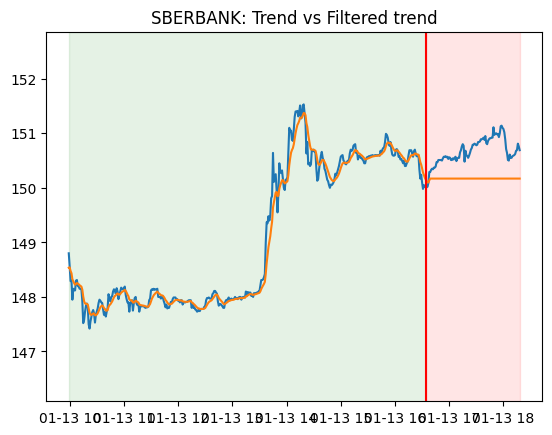

MAPE for this series: 0.0012572531947911152
1
[[0.8]] [[1.]] [[0.1]] [[0.40222667]] [[1.]] [[164.118]]
                  begin  GAZPROM_close        pred
0   2023-01-13 09:59:00         164.30  164.251269
1   2023-01-13 10:00:00         164.30  164.275399
2   2023-01-13 10:01:00         164.00  164.157932
3   2023-01-13 10:02:00         164.09  164.130553
4   2023-01-13 10:03:00         163.90  164.039589
..                  ...            ...         ...
495 2023-01-13 18:14:00         165.00  164.404549
496 2023-01-13 18:15:00         165.00  164.404549
497 2023-01-13 18:16:00         165.09  164.404549
498 2023-01-13 18:17:00         165.09  164.404549
499 2023-01-13 18:18:00         165.10  164.404549

[500 rows x 3 columns]


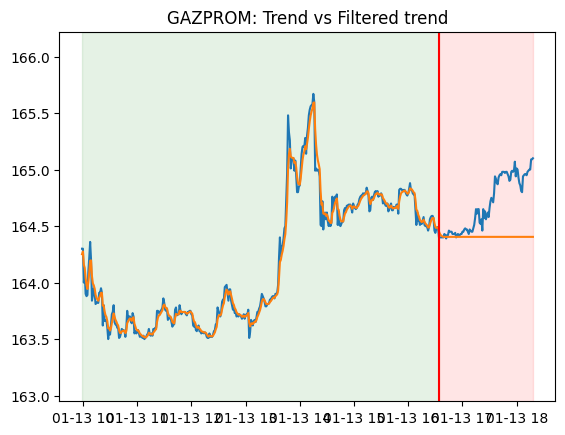

MAPE for this series: 0.0005547495158860819
1
[[0.8]] [[1.]] [[0.1]] [[16.73000496]] [[1.]] [[879.2]]
                  begin  SEVERSTAL_close        pred
0   2023-01-13 09:59:00            880.8  879.298710
1   2023-01-13 10:00:00            880.4  879.368512
2   2023-01-13 10:01:00            879.6  879.383526
3   2023-01-13 10:02:00            878.2  879.305234
4   2023-01-13 10:03:00            877.0  879.150146
..                  ...              ...         ...
495 2023-01-13 18:17:00            890.0  885.503515
496 2023-01-13 18:18:00            890.0  885.503515
497 2023-01-13 18:19:00            889.8  885.503515
498 2023-01-13 18:20:00            889.8  885.503515
499 2023-01-13 18:21:00            890.0  885.503515

[500 rows x 3 columns]


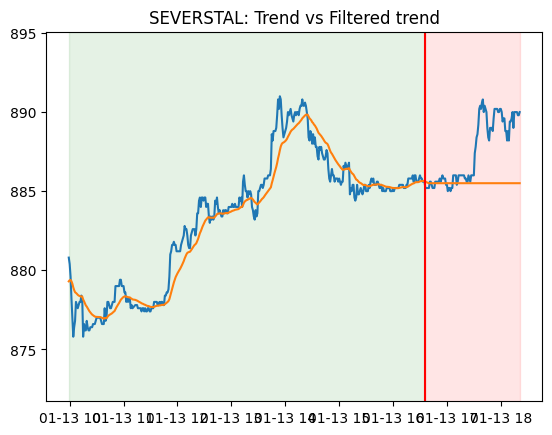

MAPE for this series: 0.0011575960544493841


In [9]:
# общая точность предсказаний

# COMPANY = "SBERBANK"
for COMPANY in companies:
    COL_GROUP = "begin"
    COL_DATA = "close"
    COL_DATA_FULL = f"{COMPANY}_{COL_DATA}"

    df_proc = df[COMPANY][[COL_GROUP, COL_DATA_FULL]].dropna()

    daily_groups = df_proc.groupby(pd.Grouper(key=COL_GROUP, freq="D"))

    filtered_data = []

    def F_func(x, t):
        return np.array([x[0]])

    def H_func(x, t):
        return np.array([x[0]])

    state_dim = 1

    for ind, (_, group) in enumerate(daily_groups):
        if not group.empty:
            if ind == 10: 
                group=group.reset_index()
                print(1)
                filter_hist_states = np.empty(shape=group.shape[0])

                F, H, Q, R, P0, x0 = generate_kalman_matrices_from_timeseries(
                    time_series_data=group.filter(like=COL_DATA), state_dimension=state_dim, process_noise_scale=0.1, measurement_noise_scale=0.1, initial_estimation_error_scale=1.0
                )

                print(F, H, Q, R, P0, x0)

                ekf = ExtendedKalmanFilter(F_func=F_func, H_func=H_func, Q=Q, R=R, x0=x0.flatten(), P0=P0)

                for t in range(0, group.shape[0]):
                    if t <= 400: 
                        observation = group.filter(like=COL_DATA).iloc[t]

                        ekf.predict(t)
                        ekf.update(observation, t)
                        filter_hist_states[t] = ekf.get_state()[0]

                    else: 
                        observation = filter_hist_states[t-1]
                        ekf.predict(t)
                        ekf.update(observation, t)
                        filter_hist_states[t] = ekf.get_state()[0]

                filtered_data.append(filter_hist_states)

                

                filtered_data = np.hstack(filtered_data)

                processed_df = pd.concat([group.begin, 
                                        group[COL_DATA_FULL],
                                        pd.DataFrame(filtered_data, columns=["pred"])], axis=1)#.dropna().reset_index()
                
                print(processed_df)
                
                top = processed_df[COL_DATA_FULL].max() + processed_df[COL_DATA_FULL].std()
                bottom = processed_df[COL_DATA_FULL].min() - processed_df[COL_DATA_FULL].std()

                plt.plot(processed_df.begin, processed_df[COL_DATA_FULL])
                plt.plot(processed_df.begin, processed_df["pred"])
                plt.axvline(processed_df.begin[400-5], color="red")

                plt.fill_between([processed_df.begin[0], processed_df.begin[0], processed_df.begin[400-5], processed_df.begin[400-5]], 
                                [bottom, top, top, bottom], alpha=.1, color="g")
                plt.fill_between([processed_df.begin[400-5], processed_df.begin[400-5], processed_df.begin[processed_df.shape[0]-1], processed_df.begin[processed_df.shape[0]-1]], 
                                [bottom, top, top, bottom], alpha=.1, color="r")
                plt.ylim(top=processed_df[COL_DATA_FULL].max() + processed_df[COL_DATA_FULL].std())
                plt.ylim(bottom=processed_df[COL_DATA_FULL].min() - processed_df[COL_DATA_FULL].std())
                plt.title(f'{COMPANY}: Trend vs Filtered trend')

                plt.show()

                print(f"MAPE for this series: {mean_absolute_percentage_error(processed_df[COL_DATA_FULL], processed_df["pred"])}")
                break


In [10]:
processed_df

,begin,SEVERSTAL_close,pred
0,2023-01-13 09:59:00,880.8,879.298710
1,2023-01-13 10:00:00,880.4,879.368512
2,2023-01-13 10:01:00,879.6,879.383526
3,2023-01-13 10:02:00,878.2,879.305234
4,2023-01-13 10:03:00,877.0,879.150146
...,...,...,...
495,2023-01-13 18:17:00,890.0,885.503515
496,2023-01-13 18:18:00,890.0,885.503515
497,2023-01-13 18:19:00,889.8,885.503515
498,2023-01-13 18:20:00,889.8,885.503515


In [11]:
# общая точность предсказаний

# COMPANY = "SBERBANK"
for COMPANY in companies:
    COL_GROUP = "begin"
    COL_DATA = "close"
    COL_DATA_FULL = f"{COMPANY}_{COL_DATA}"

    df_proc = df[COMPANY][[COL_GROUP, COL_DATA_FULL]].dropna()

    daily_groups = df_proc.groupby(pd.Grouper(key=COL_GROUP, freq="D"))

    mape_agg = []

    def F_func(x, t):
        return np.array([x[0]])

    def H_func(x, t):
        return np.array([x[0]])

    state_dim = 1

    for _, group in daily_groups:
        if not group.empty:
            filter_hist_states = np.empty(shape=group.shape[0]-400-1)

            F, H, Q, R, P0, x0 = generate_kalman_matrices_from_timeseries(
                time_series_data=group.filter(like=COL_DATA), state_dimension=state_dim, process_noise_scale=0.1, measurement_noise_scale=0.1, initial_estimation_error_scale=1.0
            )

            # print(F, H, Q, R, P0, x0)

            ekf = ExtendedKalmanFilter(F_func=F_func, H_func=H_func, Q=Q, R=R, x0=x0.flatten(), P0=P0)

            for t in range(group.shape[0]):
                if t <= 400: 
                    observation = group.filter(like=COL_DATA).iloc[t]

                    ekf.predict(t)
                    ekf.update(observation, t)
                    # filter_hist_states[t] = ekf.get_state()[0]

                else: 
                    observation = ekf.get_state()[0]
                    ekf.predict(t)
                    ekf.update(observation, t)
                    filter_hist_states[group.shape[0]-t-1] = ekf.get_state()[0]
                    
            mape_agg.append(mean_absolute_percentage_error(group[COL_DATA_FULL][401:], filter_hist_states))
            # filtered_data_var.append(filter_vars_states)

    filtered_data = np.hstack(filtered_data)        
    # filtered_data_vars = np.hstack(filtered_data_vars)

    processed_df = pd.concat([df_proc.begin, 
                            df_proc[COL_DATA_FULL],
                            pd.DataFrame(filtered_data, columns=["pred"])], axis=1).dropna()[5:].reset_index()

    print(f"MAPE avg for this series of company {COMPANY}: {np.mean(mape_agg)}")


MAPE avg for this series of company SBERBANK: 0.002040287287186992
MAPE avg for this series of company GAZPROM: 0.001869249423606854
MAPE avg for this series of company SEVERSTAL: 0.0032259990319343313
